# Подготовка модели распознавания рукописных букв и цифр:


Применение ротации и отражения к данным.

Обучение модели PyTorch.

Итоги и выводы.

# Библиотеки

In [1]:
import os
import torch
import torchvision
from torchvision.datasets import EMNIST
from torchvision import transforms
from torchvision.transforms import ToTensor, Compose, Resize, Normalize
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Получение, трансформация, нормализация и контроль данных

In [2]:
# Определение трансформаций для нормализации данных
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Нормализация по среднему и стандартному отклонению
])

In [3]:
# !!! Данная функция не применяется для обработки данных

'''Для обработки изображений х EMNIST с использованием методов Eroding, Dilating и Smoothing Images, 
 создадим функцию, для предобработки перед передачей изображений в модель'''


def preprocess_image(img):
    # Преобразуем изображение PIL в массив NumPy
    img_np = np.array(img)

    # Применяем сглаживание (Gaussian Blur)
    img_blurred = cv2.GaussianBlur(img_np, (5, 5), 0)

    # Применяем эрозию
    kernel = np.ones((3, 3), np.uint8)
    img_eroded = cv2.erode(img_blurred, kernel, iterations=1)

    # Применяем дилатацию
    img_dilated = cv2.dilate(img_eroded, kernel, iterations=1)

    # Преобразуем обратно в PIL
    img_processed = Image.fromarray(img_dilated)

    return img_processed

In [4]:
# Загрузка обучающего набора данных с трансформациями
train_data = EMNIST('data/', 'balanced', train=True, download=True,
                transform=torchvision.transforms.Compose([ 
                    # Применяем обработку изображения
                    #preprocess_image,
                    # Поворот и отражение
                    lambda img: torchvision.transforms.functional.rotate(img, -90),
                    lambda img: torchvision.transforms.functional.hflip(img),
                    transform # трансформируем и нормализуем
                ]))

100%|██████████| 562M/562M [10:47<00:00, 868kB/s]  


Extracting data/EMNIST/raw/gzip.zip to data/EMNIST/raw


In [5]:
# Загрузка тестового набора данных с трансформациями
test_data = EMNIST('data/', 'balanced', train=False,
                transform=torchvision.transforms.Compose([
                    # Применяем обработку изображения
                    #preprocess_image,
                    # Поворот и отражение
                    lambda img: torchvision.transforms.functional.rotate(img, -90),
                    lambda img: torchvision.transforms.functional.hflip(img),
                    transform # трансформируем и нормализуем
                ]))

In [6]:
# получение маппинга
with open('data/EMNIST/raw/emnist-balanced-mapping.txt', 'r') as f:
    mapping = f.readlines()

#mapping

In [7]:
# Создаем словарь соответствий
label_dict = {}
for entry in mapping:
    label, ascii_code = map(int, entry.split())
    label_dict[label] = chr(ascii_code)

In [8]:
# Подсчитываем количество тренировочных семплов для каждого лейбла
label_counts = np.bincount(train_data.targets)

# Выводим символы и количество семплов
print("Количество тренировочных семплов для каждого символа:")
for label, count in enumerate(label_counts):
    if count > 0:  # Печатаем только те лейблы, которые встречаются в выборке
        symbol = label_dict.get(label, '?')  # Получаем символ
        #print(f'Символ: {symbol}, Лейбл: {label}, Количество: {count}')

Количество тренировочных семплов для каждого символа:


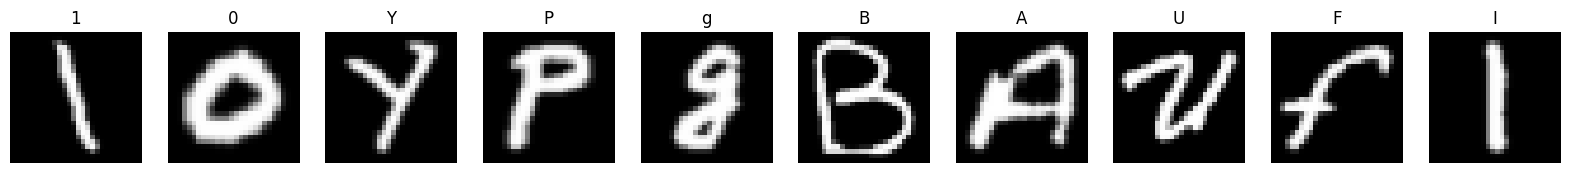

In [9]:
# Проверяем корректность изображений
fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    random_index = np.random.randint(0, len(train_data))
    #print('Random index:', random_index)
    image, label = train_data[random_index]

    # Преобразование изображения в NumPy массив для корректного отображения
    image_np = image.numpy()  # Прямое преобразование в NumPy массив

    # Убираем размерность канала (если она есть)
    if image_np.shape[0] == 1:  # Если канал один (черно-белое изображение)
        image_np = image_np.squeeze(0)  # Убираем размерность канала

    # Отображаем изображение
    axs[i].imshow(image_np, cmap='gray')
    axs[i].set_title(label_dict[label])  # Используем словарь для отображения метки
    axs[i].axis('off')

plt.show()


# Моделирование

Сверточная нейронная сеть (CNN)

In [10]:
# Очищаем состояние для последующей модели
def clear_training_state(model, optimizer):
    # Удаляем все параметры и градиенты
    model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
    optimizer.state.clear()  # Очищаем состояние оптимизатора
    optimizer.param_groups.clear()  # Очищаем группы параметров

# Используем функцию для очистки состояния
#clear_training_state(model, optimizer)

In [11]:
# Создание загрузчиков данных
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [12]:
class BigCNNModel(nn.Module):
    def __init__(self):
        super(BigCNNModel, self).__init__()
        # Первый свертка + активация + подвыборка
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # 32 фильтра
        self.bn1 = nn.BatchNorm2d(32)  # Нормализация
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Подвыборка
        # Второй свертка + активация + подвыборка
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 64 фильтра
        self.bn2 = nn.BatchNorm2d(64)  # Нормализация
        # Третий свертка
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # 128 фильтров
        self.bn3 = nn.BatchNorm2d(128)  # Нормализация
        # Полносвязные слои
        self.fc1 = nn.Linear(128 * 3 * 3, 256)  # Измените размер в зависимости от входного размера
        self.fc2 = nn.Linear(256, 47)  # Выходной слой для 47 классов
        self.dropout = nn.Dropout(0.5)  # Дропаут для регуляризации

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Свертка 1
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Свертка 2
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # Свертка 3
        x = x.view(-1, 128 * 3 * 3)  # Преобразование в вектор для полносвязного слоя
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Применение дропаута
        x = self.fc2(x)
        return x

In [13]:
# Инициализация модели
model_cnn_3 = BigCNNModel()

# Оптимизатор и функция потерь
optimizer = optim.Adam(model_cnn_3.parameters(), lr=0.001)  # Используем Adam с малой скоростью обучения
loss_function = nn.CrossEntropyLoss()  # Функция потерь для многоклассовой классификации

In [14]:
n_epochs = 10

for epoch in range(n_epochs):
    model_cnn_3.train()  # Устанавливаем режим обучения
    running_loss = 0.0

    for data, target in train_loader:
        optimizer.zero_grad()  # Обнуляем градиенты
        output = model_cnn_3(data)  # Прямой проход через модель
        loss = loss_function(output, target)  # Вычисление потерь
        loss.backward()  # Обратный проход (вычисление градиентов)
        optimizer.step()  # Обновление параметров

        running_loss += loss.item()

    print(f'Epoch {epoch + 1}/{n_epochs}, Loss: {running_loss / len(train_loader):.4f}')

    # Валидация модели после каждой эпохи
    model_cnn_3.eval()
    correct = 0

    with torch.no_grad():
        for data, target in val_loader:
            output = model_cnn_3(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    accuracy = correct / len(val_loader.dataset)
    print(f'Validation Accuracy: {accuracy:.4f}')

Epoch 1/10, Loss: 0.8245
Validation Accuracy: 0.8579
Epoch 2/10, Loss: 0.5041
Validation Accuracy: 0.8740
Epoch 3/10, Loss: 0.4441
Validation Accuracy: 0.8760
Epoch 4/10, Loss: 0.4085
Validation Accuracy: 0.8796
Epoch 5/10, Loss: 0.3803
Validation Accuracy: 0.8823
Epoch 6/10, Loss: 0.3606
Validation Accuracy: 0.8835
Epoch 7/10, Loss: 0.3419
Validation Accuracy: 0.8829
Epoch 8/10, Loss: 0.3240
Validation Accuracy: 0.8859
Epoch 9/10, Loss: 0.3085
Validation Accuracy: 0.8887
Epoch 10/10, Loss: 0.2981
Validation Accuracy: 0.8899


In [15]:
# Сохранение модели в формате .ckpt
torch.save(model_cnn_3.state_dict(), 'myapp/model.ckpt') 

In [16]:
def predict(image):
    # Применяем преобразования к изображению, если они требуются
    # image = transform(input_image)  # Примените необходимые преобразования
    # Убедитесь, что изображение имеет форму (1, 1, H, W) для модели
    if image.dim() == 2:  # Если изображение 2D (H, W)
        image = image.unsqueeze(0)  # Добавляем размер канала
    image = image.unsqueeze(0)  # Добавляем размер батча

    #print('image shape:', image.shape)

    with torch.no_grad():  # Отключаем градиенты для повышения производительности
        output = model_cnn_3(image)  # Получаем выход модели
        _, predicted_class = torch.max(output.data, 1)  # Находим класс с максимальной вероятностью
        predicted_label = predicted_class.item()  # Получаем метку класса как целое число
        #print('predicted_label:', predicted_label)

        pred = label_dict[predicted_label]  # Получаем предсказанную метку
        #print('predicted symbol:', pred)

    return pred

[W102 16:16:30.558864315 NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.


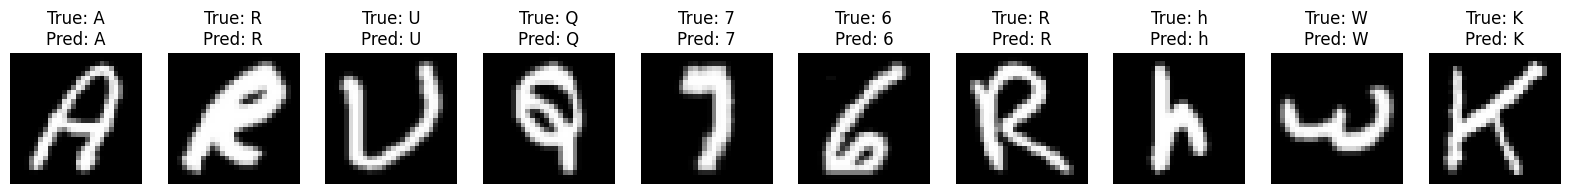

In [17]:
# Проверяем предсказания
fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    random_index = np.random.randint(0, len(train_data))
    #print('Random index:', random_index)
    image, label = train_data[random_index]

    # Преобразование изображения в NumPy массив для корректного отображения
    image_np = image.squeeze(0).numpy()  # Убираем размер канала и преобразуем в NumPy массив

    pred = predict(image)  # Предсказание для изображения

    # Отображаем изображение
    axs[i].imshow(image_np, cmap='gray')  # Используем cmap='gray' для черно-белых изображений
    # Добавляем отображение истинной метки и предсказанного значения
    axs[i].set_title(f'True: {label_dict[label]}\nPred: {pred}')
    axs[i].axis('off')

plt.show()


# Итоги зкспериментов и выводы:


    Изображение загружается в оттенках серого.
    Применяется гауссов фильтр для сглаживания.
    Бинаризация выполняется с использованием порогового значения.
    Эрозия применяется для удаления мелких шумов.
    Дилатация восстанавливает целостность символов.

Этот подход поможет улучшить качество входных данных для модели EMNIST и повысит точность распознавания рукописных символов.
